In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from qr_decomposition.wikidata.inference import predict_embedding as predict_embedding_wikidata
from qr_decomposition.utils import resolve_path

In [3]:
dataset_path = resolve_path("dataset/jigsaw_wikidata.parquet")
train_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'train'").to_df()
val_df = duckdb.sql(f"SELECT * FROM '{dataset_path}' WHERE split = 'val'").to_df()

len(train_df), len(val_df)

(127534, 32037)

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang,embeddings,split
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,en,"[0.06416848301887512, 0.017569249495863914, -0...",train
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,en,"[-0.022229451686143875, -0.05195361375808716, ...",train
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,en,"[0.006937406025826931, -0.010694167576730251, ...",train
3,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,en,"[0.059962037950754166, -0.015832973644137383, ...",train
4,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,en,"[0.027675701305270195, 0.00032216860563494265,...",train


In [5]:
def print_pca_stats(pca_data):
    for i in range(2):  # for first two PCs
        print(f"\nPC{i + 1} Statistics:")
        print(f"Mean: {np.mean(pca_data[:, i]):.3f}")
        print(f"Std: {np.std(pca_data[:, i]):.3f}")
        print(f"Min: {np.min(pca_data[:, i]):.3f}")
        print(f"Max: {np.max(pca_data[:, i]):.3f}")
        print(f"25th percentile: {np.percentile(pca_data[:, i], 25):.3f}")
        print(f"Median: {np.median(pca_data[:, i]):.3f}")
        print(f"75th percentile: {np.percentile(pca_data[:, i], 75):.3f}")

In [6]:
val_X = val_df["embeddings"]
val_X = np.array([np.array(emb) for emb in val_X])
val_X_labels = np.array([
    val_df["toxic"],
    val_df["severe_toxic"],
    val_df["obscene"],
    val_df["threat"],
    val_df["insult"],
    val_df["identity_hate"],
])

val_X.shape

(32037, 1536)

In [7]:
# pca = PCA(n_components=2)
# val_X_pca = pca.fit_transform(val_X)

# # Create boolean masks for each class
# positive_mask = np.array([label == "positive" for label in val_X_labels])
# negative_mask = ~positive_mask

# plt.figure(figsize=(10, 8))
# # Plot each class separately
# plt.scatter(
#     val_X_pca[positive_mask, 0], val_X_pca[positive_mask, 1], c="red", alpha=0.2, label="positive"
# )
# plt.scatter(
#     val_X_pca[negative_mask, 0], val_X_pca[negative_mask, 1], c="blue", alpha=0.2, label="negative"
# )
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.legend()
# plt.title("PCA of IMDB Reviews")
# plt.show()

In [8]:
# print_pca_stats(val_X_pca)

In [27]:
toxic_train_df = train_df[train_df["toxic"] == 1]
emb_toxic = np.array([np.array(emb) for emb in toxic_train_df["embeddings"]])

severe_toxic_train_df = train_df[train_df["severe_toxic"] == 1]
emb_severe_toxic = np.array([np.array(emb) for emb in severe_toxic_train_df["embeddings"]])

obscene_train_df = train_df[train_df["obscene"] == 1]
emb_obscene = np.array([np.array(emb) for emb in obscene_train_df["embeddings"]])

threat_train_df = train_df[train_df["threat"] == 1]
emb_threat = np.array([np.array(emb) for emb in threat_train_df["embeddings"]])

identity_hate_train_df = train_df[train_df["identity_hate"] == 1]
emb_identity_hate = np.array([np.array(emb) for emb in identity_hate_train_df["embeddings"]])

emb_all = np.array([np.array(emb) for emb in train_df["embeddings"]])

(
    emb_toxic.shape,
    emb_severe_toxic.shape,
    emb_obscene.shape,
    emb_threat.shape,
    emb_identity_hate.shape,
    emb_all.shape,
)

((12159, 1536),
 (1249, 1536),
 (6727, 1536),
 (381, 1536),
 (1117, 1536),
 (127534, 1536))

In [32]:
k = 150
Q_all = PCA(n_components=k).fit_transform(emb_all.T)

Q_toxic = PCA(n_components=k).fit_transform(emb_toxic.T)
Q_severe_toxic = PCA(n_components=k).fit_transform(emb_severe_toxic.T)
Q_obscene = PCA(n_components=k).fit_transform(emb_obscene.T)
Q_threat = PCA(n_components=k).fit_transform(emb_threat.T)
Q_identity_hate = PCA(n_components=k).fit_transform(emb_identity_hate.T)

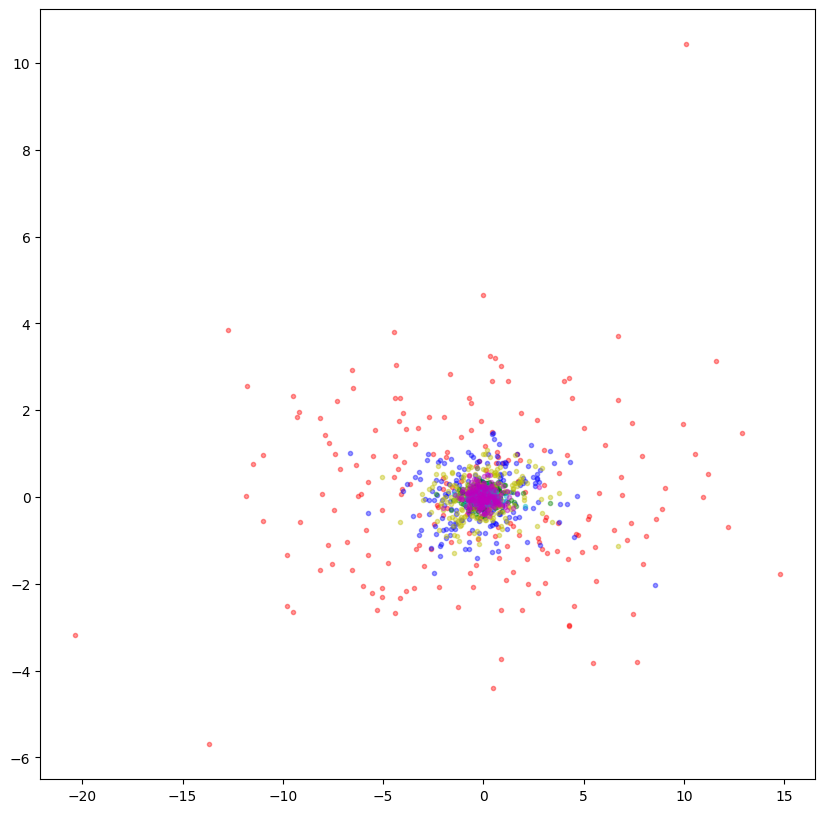

In [31]:
plt.figure(figsize=(10, 10))
plt.plot(Q_all[:k, 0], Q_all[:k, 1], "r.", alpha=0.4)
plt.plot(Q_toxic[:k, 0], Q_toxic[:k, 1], "b.", alpha=0.4)
plt.plot(Q_severe_toxic[:k, 0], Q_severe_toxic[:k, 1], "g.", alpha=0.4)
plt.plot(Q_obscene[:k, 0], Q_obscene[:k, 1], "y.", alpha=0.4)
plt.plot(Q_threat[:k, 0], Q_threat[:k, 1], "c.", alpha=0.4)
plt.plot(Q_identity_hate[:k, 0], Q_identity_hate[:k, 1], "m.", alpha=0.4)
plt.show()

In [12]:
def remove_common_component(q, Q_common):
    # Project q onto the common review subspace
    proj = Q_common @ (Q_common.T @ q)
    return q - proj


Q_obscene, R_obscene = np.linalg.qr(emb_obscene.T)
Q_identity_hate, R_identity_hate = np.linalg.qr(emb_identity_hate.T)
Q_obscene_sent = np.array([remove_common_component(q, Q_all) for q in Q_obscene.T]).T
Q_identity_hate_sent = np.array([remove_common_component(q, Q_all) for q in Q_identity_hate.T]).T

In [13]:
Q_obscene_sentiment, R_obscene_sentiment = np.linalg.qr(Q_obscene_sent)

v = emb_obscene[0]  # Example positive review embedding, shape: (d,)
v_sentiment = v @ Q_obscene_sentiment @ Q_obscene_sentiment.T
v_common = v @ Q_all @ Q_all.T
v_other = v - (v_common + v_sentiment)

reconstruction_error = np.linalg.norm(v - (v_common + v_sentiment + v_other))
print("Reconstruction error:", reconstruction_error)

# Optionally, check orthogonality:
orthogonality = [np.dot(v_sentiment, q) for q in Q_all.T]
print("Average dot product with Q_all:", np.mean(orthogonality))

Reconstruction error: 0.0
Average dot product with Q_all: 0.527659857385062


In [14]:
Q_identity_hate_sentiment, R_identity_hate_sentiment = np.linalg.qr(Q_identity_hate_sent)
v = emb_identity_hate[0]
v_sentiment = v @ Q_identity_hate_sentiment @ Q_identity_hate_sentiment.T
v_common = v @ Q_all @ Q_all.T
v_other = v - (v_common + v_sentiment)

reconstruction_error = np.linalg.norm(v - (v_common + v_sentiment + v_other))
print("Reconstruction error:", reconstruction_error)

orthogonality = [np.dot(v_sentiment, q) for q in Q_all.T]
print("Average dot product with Q_all:", np.mean(orthogonality))

Reconstruction error: 1.4210854715202004e-14
Average dot product with Q_all: 0.4030818858988947


In [22]:
# Calculate co-occurrence probabilities for obscene comments
obscene_mask = val_df["threat"] == 1
properties = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

print("For obscene comments, probability of also being:")
for prop in properties:
    prob = val_df[obscene_mask][prop].mean()
    print(f"{prop:12s}: {prob:.3f}")


For obscene comments, probability of also being:
toxic       : 0.948
severe_toxic: 0.268
obscene     : 0.701
threat      : 1.000
insult      : 0.711
identity_hate: 0.216


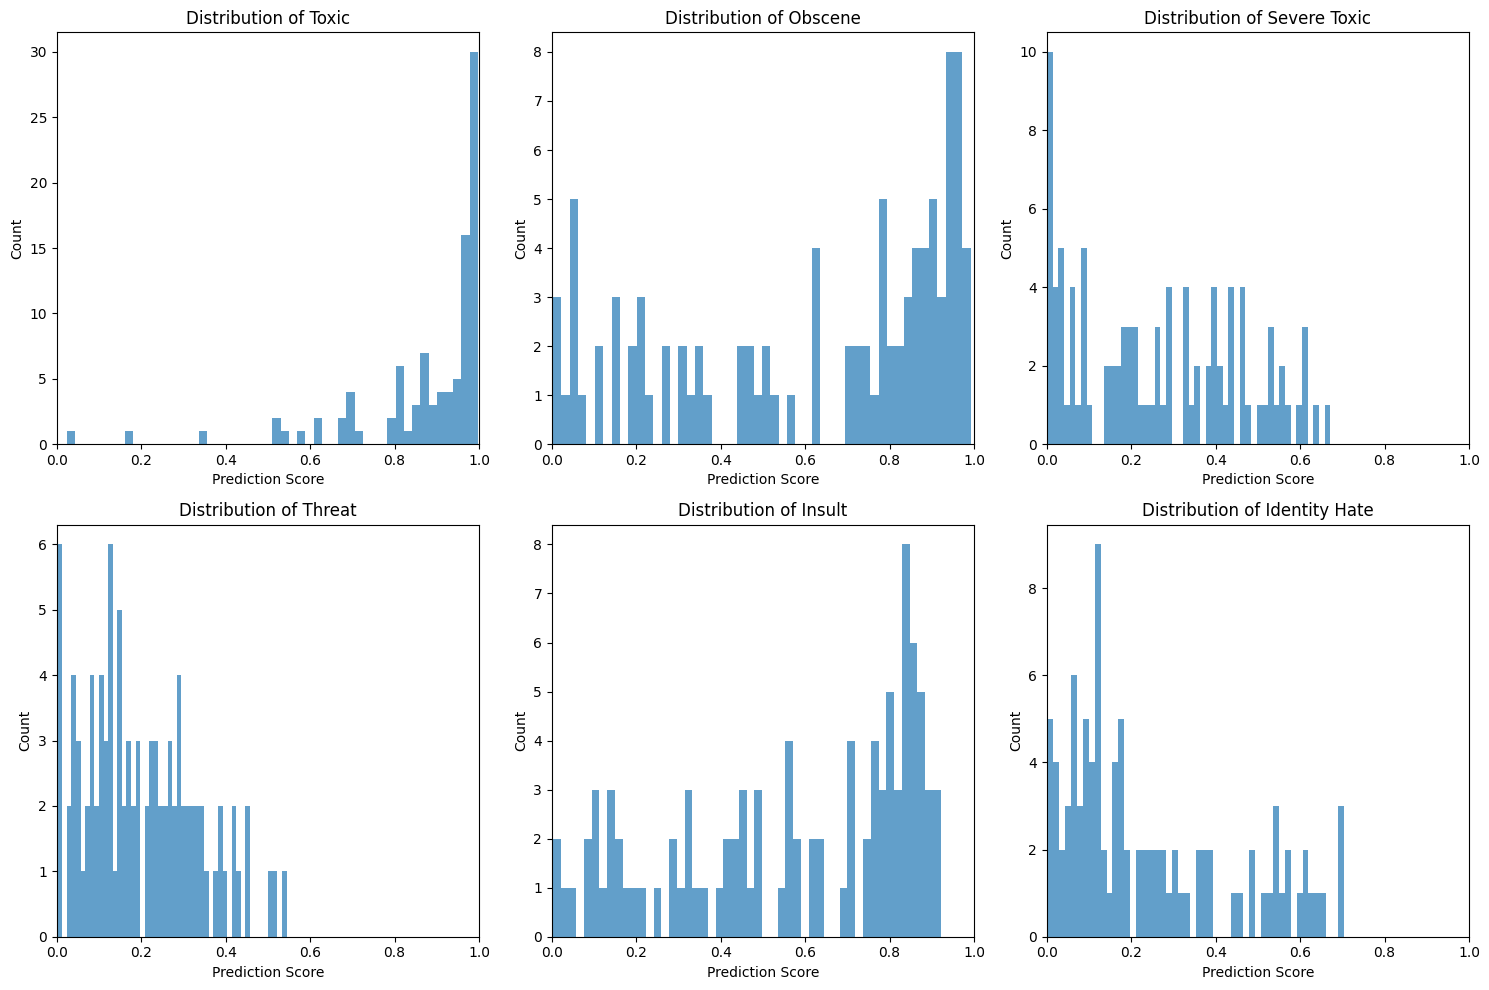

In [25]:
val_obscene = val_df[val_df["threat"] == 1]
val_obscene_emb = np.array([np.array(emb) for emb in val_obscene["embeddings"]])
predictions = predict_embedding_wikidata(val_obscene_emb)

pred_dict = {key: [pred[key] for pred in predictions] for key in predictions[0].keys()}

properties = ["toxic", "obscene", "severe_toxic", "threat", "insult", "identity_hate"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, prop in enumerate(properties):
    axes[i].hist(pred_dict[prop], bins=50, alpha=0.7)
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel("Prediction Score")
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Distribution of {prop.replace('_', ' ').title()}")

plt.tight_layout()
plt.show()


Norm difference from original: 7.879086326298962


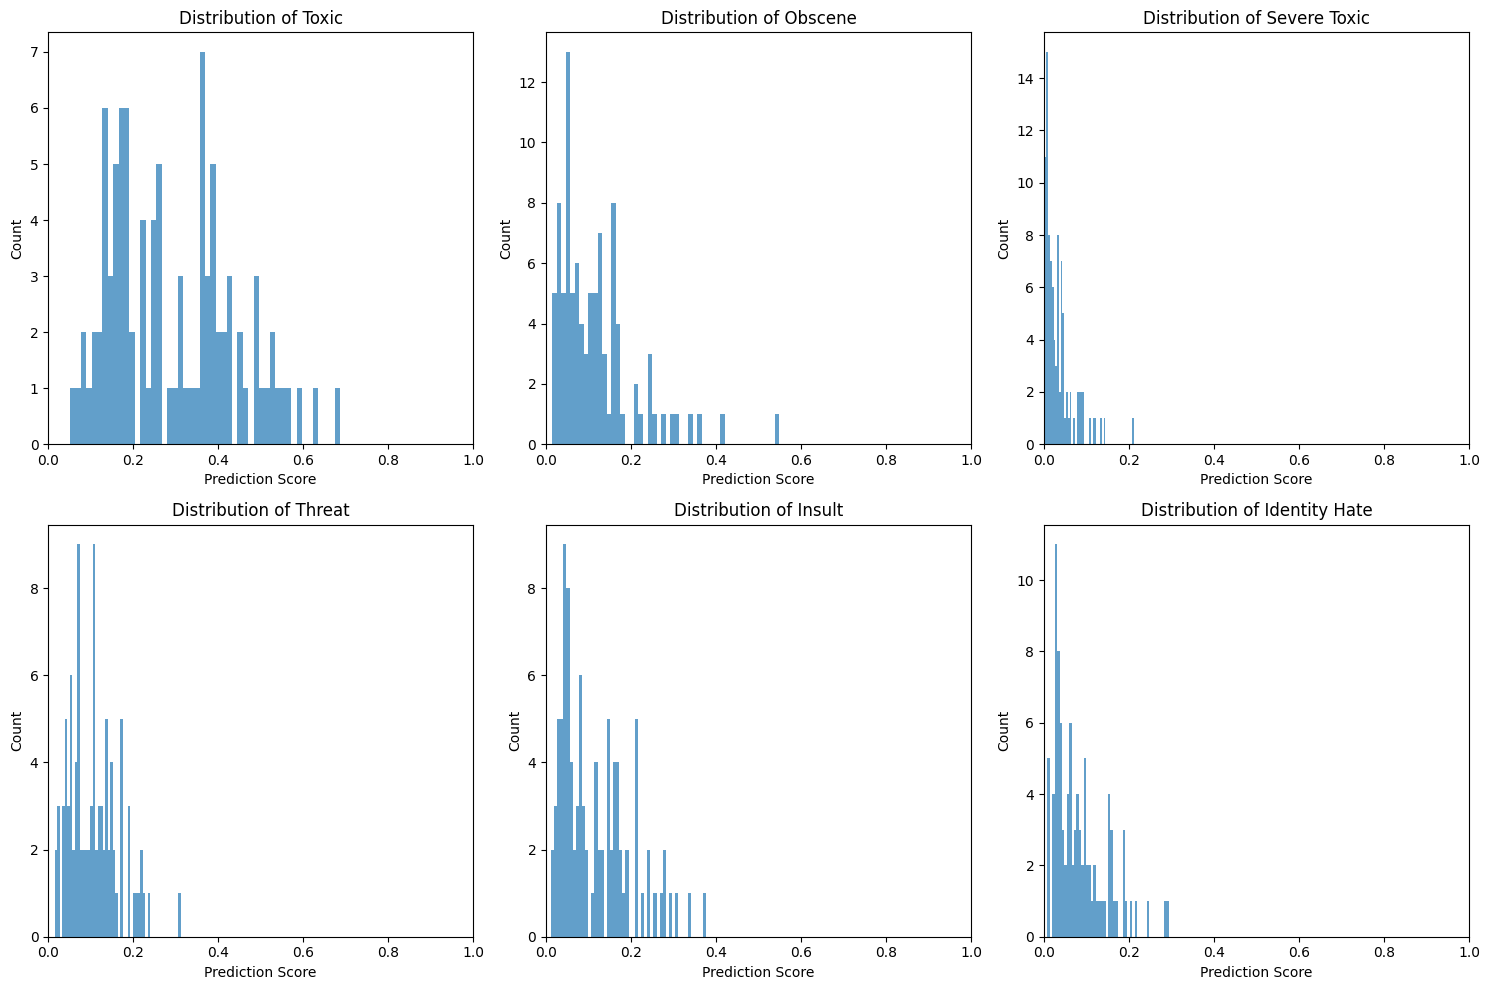

In [26]:
alpha = 0.2
beta = 1.0
gamma = 1.0

val_obscene_X = val_obscene_emb
val_obscene_X_v_sentiment = val_obscene_X @ Q_obscene_sentiment @ Q_obscene_sentiment.T
val_obscene_X_v_common = val_obscene_X @ Q_all @ Q_all.T
val_obscene_X_v_other = val_obscene_X - (val_obscene_X_v_common + val_obscene_X_v_sentiment)

val_obscene_X_v_adjusted = (val_obscene_X_v_common * beta) + (val_obscene_X_v_other * gamma) + (val_obscene_X_v_sentiment * alpha)
val_obscene_X_predictions = predict_embedding_wikidata(val_obscene_X_v_adjusted)
print("Norm difference from original:", np.linalg.norm(val_obscene_X - val_obscene_X_v_adjusted))

pred_dict = {key: [pred[key] for pred in val_obscene_X_predictions] for key in val_obscene_X_predictions[0].keys()}

properties = ["toxic", "obscene", "severe_toxic", "threat", "insult", "identity_hate"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, prop in enumerate(properties):
    axes[i].hist(pred_dict[prop], bins=50, alpha=0.7)
    axes[i].set_xlim(0, 1)
    axes[i].set_xlabel("Prediction Score")
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"Distribution of {prop.replace('_', ' ').title()}")

plt.tight_layout()
plt.show()
